<center><h1>MYS Cross-border e-commerce product data cleaning</h1></center>

In [1]:
import os
import sys
from datetime import datetime
from typing import List, Union
import matplotlib.pyplot as plt
plt.style.use('bmh')
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
from pathlib import Path
import holidays
import pickle
import torch
from sklearn.decomposition import PCA
import re
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter("error", category=SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
from sklearn.preprocessing import MinMaxScaler

In [2]:
from transformers import BertTokenizer, BertModel

In [3]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.tuner import Tuner

In [4]:
from pytorch_forecasting import Baseline, GroupNormalizer, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data.examples import get_stallion_data
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.utils import profile

In [5]:
from pytorch_lightning.loggers import TensorBoardLogger

# Initialize TensorBoardLogger with a save directory
logger = TensorBoardLogger(save_dir='logs', name='my_experiment')

In [6]:
from utils import add_cyclical_calendar_features, check_na, get_missing_dates

In [7]:
import os

# Define the path
log_dir = "./models/lightning_logs"

# Check if the directory exists, if not, create it
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

print(f"Directory {log_dir} is ready.")


Directory ./models/lightning_logs is ready.


In [8]:
SAVE_DIR = './models'
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

In [9]:
DATAPATH = Path("./")

In [10]:
data1= pd.read_csv(DATAPATH /"my_live.csv")
data2= pd.read_csv(DATAPATH /"my_top10_live.csv")
column_names1 = data1.columns
column_names1

Index(['id', 'st', 'et', 'create_time', 'shortUrl', 'handle', 'unit_price',
       'title', 'record_type', 'finish_time', 'is_purchase', 'duration',
       'screenshotUrl', 'sale', 'revenue', 'live_id', 'views'],
      dtype='object')

In [11]:
data1

,id,st,et,create_time,shortUrl,handle,unit_price,title,record_type,finish_time,is_purchase,duration,screenshotUrl,sale,revenue,live_id,views
0,1729416661936801881,2024-01-10,2024-07-04,2024/03/05 00:00:59,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/05 12:52:42,False,12h 51m,NaN,9,$41.82,NaN,31669
1,1729416661936801881,2024-01-10,2024-07-04,2024/03/06 12:02:14,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,FULL,2024/03/07 00:01:44,False,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8,$37.19,NaN,26694
2,1729416661936801881,2024-01-10,2024-07-04,2024/03/06 00:00:57,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/06 12:00:28,False,11h 59m,NaN,8,$37.19,NaN,29285
3,1729416661936801881,2024-01-10,2024-07-04,2024/03/04 00:02:03,NaN,wardahbeauty_my,$4.66,SUPER BRAND DAY!,FULL,2024/03/04 16:00:31,False,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7,$32.60,NaN,38491
4,1729416661936801881,2024-01-10,2024-07-04,2024/03/28 18:11:09,NaN,wardahbeauty_my,$4.65,RAMADHAN SPECIAL 70% - HANYA,SCREENSHOT,2024/03/29 02:14:20,False,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7,$32.55,NaN,43292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677287,1729569351181568676,2024-01-10,2024-07-04,2024/01/11 10:11:37,NaN,a.lyaadurrah2,NaN,bawak apa dlm bag skincare,SCREENSHOT,2024/01/11 10:52:30,False,40m,https://live.kalowave.cn/live/7322657494298331...,0,¥0.00,NaN,121
677288,1729569351181568676,2024-01-10,2024-07-04,2024/01/11 08:28:39,NaN,healezofficial,NaN,JERAWAT PARUT KUSAM HILANG?!,SCREENSHOT,2024/01/11 10:37:36,False,2h 8m,https://live.kalowave.cn/live/7322630907859421...,0,¥0.00,NaN,1227
677289,1729569351181568676,2024-01-10,2024-07-04,2024/01/11 02:17:47,NaN,mamishass,NaN,Test Live jee,SCREENSHOT,2024/01/11 02:45:47,False,28m,https://live.kalowave.cn/live/7322535169766755...,0,¥0.00,NaN,386
677290,1729569351181568676,2024-01-10,2024-07-04,2024/01/10 17:39:42,NaN,helmiismail22,NaN,JomGlowingSebelumRaya,SCREENSHOT,2024/01/10 18:39:58,False,1h,https://live.kalowave.cn/live/7322401948031470...,0,¥0.00,NaN,286


In [12]:
column_names2 = data2.columns
column_names2

Index(['id', 'st', 'et', 'create_time', 'shortUrl', 'handle', 'unit_price',
       'title', 'record_type', 'finish_time', 'is_purchase', 'duration',
       'screenshotUrl', 'sale', 'revenue', 'live_id', 'views'],
      dtype='object')

In [13]:
data2

,id,st,et,create_time,shortUrl,handle,unit_price,title,record_type,finish_time,is_purchase,duration,screenshotUrl,sale,revenue,live_id,views
0,1729431865044863511,2024-01-10,2024-07-04,2024/06/20 08:03:34,https://live.kalowave.cn/live_short/7382369108...,lihyingg0330,$8.28,TikTok Shop Super Creator,SHORT,2024/06/21 08:07:18,False,24h 3m,https://live.kalowave.cn/live/7382369108691405...,682,$5646.00,NaN,474528
1,1729431865044863511,2024-01-10,2024-07-04,2024/05/25 08:54:13,NaN,lihyingg0330,$8.28,Pyjamas dress RM10,SCREENSHOT,2024/05/26 00:09:57,False,15h 15m,https://live.kalowave.cn/live/7372733889666321...,538,$4453.36,NaN,266582
2,1729431865044863511,2024-01-10,2024-07-04,2024/06/22 14:04:27,https://live.kalowave.cn/live_short/7383204363...,lihyingg0330,$8.27,TikTok Shop Super Creator,SHORT,2024/06/23 03:01:58,False,12h 57m,https://live.kalowave.cn/live/7383204363721804...,501,$4145.73,NaN,261849
3,1729431865044863511,2024-01-10,2024-07-04,2024/05/06 09:59:53,NaN,tiktokshopbeauty.my,$8.23,PERFUME LONKOOM MURAH ‼️Huzai,SCREENSHOT,2024/05/06 15:59:55,False,6h,https://live.kalowave.cn/live/7365700274319133...,422,$3472.92,NaN,31370
4,1729431865044863511,2024-01-10,2024-07-04,2024/05/19 08:00:12,NaN,tiktokshopbeauty.my,$8.32,TikTok Shop Super Creator,SCREENSHOT,2024/05/20 00:36:39,False,16h 36m,https://live.kalowave.cn/live/7370493135832500...,283,$2354.56,NaN,198039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44309,1729683668878264664,2024-01-10,2024-07-04,2024/01/30 22:51:44,NaN,_.shallll,NaN,Halu mumuis 🫶🏻,SCREENSHOT,2024/01/30 22:58:19,False,6m,NaN,0,$0.00,NaN,45
44310,1729683668878264664,2024-01-10,2024-07-04,2024/05/24 00:41:29,NaN,lenshoptiktok,NaN,Lipbalm rm5 casing iphone rm1,SCREENSHOT,2024/05/24 01:33:12,False,51m,https://live.kalowave.cn/live/7372235970089569...,0,$0.00,NaN,252
44311,1729683668878264664,2024-01-10,2024-07-04,2024/05/29 14:38:43,NaN,jurainisharing,NaN,CPG COSMETICS,SCREENSHOT,2024/05/29 15:46:23,False,1h 7m,https://live.kalowave.cn/live/7374307176518568...,0,$0.00,NaN,349
44312,1729683668878264664,2024-01-10,2024-07-04,2024/05/30 14:37:40,NaN,jurainisharing,NaN,MAI SINGAH HAMPA,SCREENSHOT,2024/05/30 15:46:01,False,1h 8m,https://live.kalowave.cn/live/7374677886793566...,0,$0.00,NaN,378


In [14]:
# Merge
train_df= pd.concat([data1, data2], ignore_index=True)
train_df

,id,st,et,create_time,shortUrl,handle,unit_price,title,record_type,finish_time,is_purchase,duration,screenshotUrl,sale,revenue,live_id,views
0,1729416661936801881,2024-01-10,2024-07-04,2024/03/05 00:00:59,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/05 12:52:42,False,12h 51m,NaN,9,$41.82,NaN,31669
1,1729416661936801881,2024-01-10,2024-07-04,2024/03/06 12:02:14,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,FULL,2024/03/07 00:01:44,False,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8,$37.19,NaN,26694
2,1729416661936801881,2024-01-10,2024-07-04,2024/03/06 00:00:57,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/06 12:00:28,False,11h 59m,NaN,8,$37.19,NaN,29285
3,1729416661936801881,2024-01-10,2024-07-04,2024/03/04 00:02:03,NaN,wardahbeauty_my,$4.66,SUPER BRAND DAY!,FULL,2024/03/04 16:00:31,False,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7,$32.60,NaN,38491
4,1729416661936801881,2024-01-10,2024-07-04,2024/03/28 18:11:09,NaN,wardahbeauty_my,$4.65,RAMADHAN SPECIAL 70% - HANYA,SCREENSHOT,2024/03/29 02:14:20,False,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7,$32.55,NaN,43292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721601,1729683668878264664,2024-01-10,2024-07-04,2024/01/30 22:51:44,NaN,_.shallll,NaN,Halu mumuis 🫶🏻,SCREENSHOT,2024/01/30 22:58:19,False,6m,NaN,0,$0.00,NaN,45
721602,1729683668878264664,2024-01-10,2024-07-04,2024/05/24 00:41:29,NaN,lenshoptiktok,NaN,Lipbalm rm5 casing iphone rm1,SCREENSHOT,2024/05/24 01:33:12,False,51m,https://live.kalowave.cn/live/7372235970089569...,0,$0.00,NaN,252
721603,1729683668878264664,2024-01-10,2024-07-04,2024/05/29 14:38:43,NaN,jurainisharing,NaN,CPG COSMETICS,SCREENSHOT,2024/05/29 15:46:23,False,1h 7m,https://live.kalowave.cn/live/7374307176518568...,0,$0.00,NaN,349
721604,1729683668878264664,2024-01-10,2024-07-04,2024/05/30 14:37:40,NaN,jurainisharing,NaN,MAI SINGAH HAMPA,SCREENSHOT,2024/05/30 15:46:01,False,1h 8m,https://live.kalowave.cn/live/7374677886793566...,0,$0.00,NaN,378


In [15]:
check_na(train_df)

id                 0.000000
st                 0.000000
et                 0.000000
create_time        0.000000
shortUrl          90.329626
handle             0.008592
unit_price        46.399836
title              2.422790
record_type        0.000000
finish_time        0.000000
is_purchase        0.000000
duration           0.056956
screenshotUrl     19.710202
sale               0.000000
revenue            0.000000
live_id          100.000000
views              0.000000
dtype: float64

**Time distribution of observation data**

In [16]:
# Find the earliest date and time
train_df['create_time']  = pd.to_datetime(train_df['create_time'])
earliest_date = train_df['create_time'].min()
earliest_date 

Timestamp('2024-01-10 04:01:52')

DATA CLEANING

In [17]:
# Convert the specified column 'df' to floating point type
train_df['sale'] = train_df['sale'].astype(float)

In [18]:
# Mark duplicate lines first
train_df['is_duplicate'] = train_df.duplicated(subset=['id', 'create_time', 'unit_price','title','sale','views'	], keep=False)
# Remove duplicate rows
train_df = train_df[~train_df['is_duplicate']].drop(columns='is_duplicate')
train_df = train_df.reset_index(drop=True)
train_df

,id,st,et,create_time,shortUrl,handle,unit_price,title,record_type,finish_time,is_purchase,duration,screenshotUrl,sale,revenue,live_id,views
0,1729416661936801881,2024-01-10,2024-07-04,2024-03-05 00:00:59,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/05 12:52:42,False,12h 51m,NaN,9.0,$41.82,NaN,31669
1,1729416661936801881,2024-01-10,2024-07-04,2024-03-06 12:02:14,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,FULL,2024/03/07 00:01:44,False,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,$37.19,NaN,26694
2,1729416661936801881,2024-01-10,2024-07-04,2024-03-06 00:00:57,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/06 12:00:28,False,11h 59m,NaN,8.0,$37.19,NaN,29285
3,1729416661936801881,2024-01-10,2024-07-04,2024-03-04 00:02:03,NaN,wardahbeauty_my,$4.66,SUPER BRAND DAY!,FULL,2024/03/04 16:00:31,False,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,$32.60,NaN,38491
4,1729416661936801881,2024-01-10,2024-07-04,2024-03-28 18:11:09,NaN,wardahbeauty_my,$4.65,RAMADHAN SPECIAL 70% - HANYA,SCREENSHOT,2024/03/29 02:14:20,False,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,$32.55,NaN,43292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495261,1729683668878264664,2024-01-10,2024-07-04,2024-01-30 22:51:44,NaN,_.shallll,NaN,Halu mumuis 🫶🏻,SCREENSHOT,2024/01/30 22:58:19,False,6m,NaN,0.0,$0.00,NaN,45
495262,1729683668878264664,2024-01-10,2024-07-04,2024-05-24 00:41:29,NaN,lenshoptiktok,NaN,Lipbalm rm5 casing iphone rm1,SCREENSHOT,2024/05/24 01:33:12,False,51m,https://live.kalowave.cn/live/7372235970089569...,0.0,$0.00,NaN,252
495263,1729683668878264664,2024-01-10,2024-07-04,2024-05-29 14:38:43,NaN,jurainisharing,NaN,CPG COSMETICS,SCREENSHOT,2024/05/29 15:46:23,False,1h 7m,https://live.kalowave.cn/live/7374307176518568...,0.0,$0.00,NaN,349
495264,1729683668878264664,2024-01-10,2024-07-04,2024-05-30 14:37:40,NaN,jurainisharing,NaN,MAI SINGAH HAMPA,SCREENSHOT,2024/05/30 15:46:01,False,1h 8m,https://live.kalowave.cn/live/7374677886793566...,0.0,$0.00,NaN,378


In [19]:
# Delete duplicate rows with the same values ​​in the 'id' and 'create_time' columns to avoid data duplication caused by crawlers
train_df= train_df.drop_duplicates(subset=['id', 'create_time'])
train_df

,id,st,et,create_time,shortUrl,handle,unit_price,title,record_type,finish_time,is_purchase,duration,screenshotUrl,sale,revenue,live_id,views
0,1729416661936801881,2024-01-10,2024-07-04,2024-03-05 00:00:59,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/05 12:52:42,False,12h 51m,NaN,9.0,$41.82,NaN,31669
1,1729416661936801881,2024-01-10,2024-07-04,2024-03-06 12:02:14,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,FULL,2024/03/07 00:01:44,False,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,$37.19,NaN,26694
2,1729416661936801881,2024-01-10,2024-07-04,2024-03-06 00:00:57,NaN,wardahbeauty_my,$4.65,SUPER BRAND DAY!,SCREENSHOT,2024/03/06 12:00:28,False,11h 59m,NaN,8.0,$37.19,NaN,29285
3,1729416661936801881,2024-01-10,2024-07-04,2024-03-04 00:02:03,NaN,wardahbeauty_my,$4.66,SUPER BRAND DAY!,FULL,2024/03/04 16:00:31,False,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,$32.60,NaN,38491
4,1729416661936801881,2024-01-10,2024-07-04,2024-03-28 18:11:09,NaN,wardahbeauty_my,$4.65,RAMADHAN SPECIAL 70% - HANYA,SCREENSHOT,2024/03/29 02:14:20,False,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,$32.55,NaN,43292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495261,1729683668878264664,2024-01-10,2024-07-04,2024-01-30 22:51:44,NaN,_.shallll,NaN,Halu mumuis 🫶🏻,SCREENSHOT,2024/01/30 22:58:19,False,6m,NaN,0.0,$0.00,NaN,45
495262,1729683668878264664,2024-01-10,2024-07-04,2024-05-24 00:41:29,NaN,lenshoptiktok,NaN,Lipbalm rm5 casing iphone rm1,SCREENSHOT,2024/05/24 01:33:12,False,51m,https://live.kalowave.cn/live/7372235970089569...,0.0,$0.00,NaN,252
495263,1729683668878264664,2024-01-10,2024-07-04,2024-05-29 14:38:43,NaN,jurainisharing,NaN,CPG COSMETICS,SCREENSHOT,2024/05/29 15:46:23,False,1h 7m,https://live.kalowave.cn/live/7374307176518568...,0.0,$0.00,NaN,349
495264,1729683668878264664,2024-01-10,2024-07-04,2024-05-30 14:37:40,NaN,jurainisharing,NaN,MAI SINGAH HAMPA,SCREENSHOT,2024/05/30 15:46:01,False,1h 8m,https://live.kalowave.cn/live/7374677886793566...,0.0,$0.00,NaN,378


In [20]:
# Delete unnecessary variables
train_df = train_df.drop(columns=["st", "et","handle","finish_time","is_purchase","live_id","record_type"
                                  ,"shortUrl","revenue"])
train_df

,id,create_time,unit_price,title,duration,screenshotUrl,sale,views
0,1729416661936801881,2024-03-05 00:00:59,$4.65,SUPER BRAND DAY!,12h 51m,NaN,9.0,31669
1,1729416661936801881,2024-03-06 12:02:14,$4.65,SUPER BRAND DAY!,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,26694
2,1729416661936801881,2024-03-06 00:00:57,$4.65,SUPER BRAND DAY!,11h 59m,NaN,8.0,29285
3,1729416661936801881,2024-03-04 00:02:03,$4.66,SUPER BRAND DAY!,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,38491
4,1729416661936801881,2024-03-28 18:11:09,$4.65,RAMADHAN SPECIAL 70% - HANYA,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,43292
...,...,...,...,...,...,...,...,...
495261,1729683668878264664,2024-01-30 22:51:44,NaN,Halu mumuis 🫶🏻,6m,NaN,0.0,45
495262,1729683668878264664,2024-05-24 00:41:29,NaN,Lipbalm rm5 casing iphone rm1,51m,https://live.kalowave.cn/live/7372235970089569...,0.0,252
495263,1729683668878264664,2024-05-29 14:38:43,NaN,CPG COSMETICS,1h 7m,https://live.kalowave.cn/live/7374307176518568...,0.0,349
495264,1729683668878264664,2024-05-30 14:37:40,NaN,MAI SINGAH HAMPA,1h 8m,https://live.kalowave.cn/live/7374677886793566...,0.0,378


In [21]:
# Count the number of null values ​​in each variable
nan_count = train_df.isna().sum()
nan_count

id                    0
create_time           0
unit_price       137229
title             10528
duration            164
screenshotUrl     88830
sale                  0
views                 0
dtype: int64

In [22]:
# Remove any rows containing NaN values
train_df = train_df.dropna()
train_df

,id,create_time,unit_price,title,duration,screenshotUrl,sale,views
1,1729416661936801881,2024-03-06 12:02:14,$4.65,SUPER BRAND DAY!,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,26694
3,1729416661936801881,2024-03-04 00:02:03,$4.66,SUPER BRAND DAY!,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,38491
4,1729416661936801881,2024-03-28 18:11:09,$4.65,RAMADHAN SPECIAL 70% - HANYA,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,43292
7,1729416661936801881,2024-01-30 10:46:34,$3.49,Payday Sale 40% OFF! - Deana,3h 11m,https://live.kalowave.cn/live/7329716600804870...,7.0,3025
8,1729416661936801881,2024-06-07 12:15:29,$5.86,6.6 TIKTOK BIRTHDAY PARTY!,12h,https://live.kalowave.cn/live/7377609633727286...,4.0,8424
...,...,...,...,...,...,...,...,...
495249,1729683668878264664,2024-05-29 20:48:25,$5.32,Lipbalm rm5,35m,https://live.kalowave.cn/live/7374402472007224...,14.0,315
495250,1729683668878264664,2024-01-25 20:58:00,$6.32,Halu mumuis 🫶🏻,1h 4m,https://live.kalowave.cn/live/7328019125859470...,11.0,352
495251,1729683668878264664,2024-05-29 00:32:48,$5.32,Lipbalm rm5 casing iphone 30sen,1h 17m,https://live.kalowave.cn/live/7374089185814973...,12.0,562
495253,1729683668878264664,2024-05-29 14:20:47,$5.32,Lipbalm rm5,20m,https://live.kalowave.cn/live/7374302541439421...,8.0,181


In [23]:
train_df 

,id,create_time,unit_price,title,duration,screenshotUrl,sale,views
1,1729416661936801881,2024-03-06 12:02:14,$4.65,SUPER BRAND DAY!,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,26694
3,1729416661936801881,2024-03-04 00:02:03,$4.66,SUPER BRAND DAY!,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,38491
4,1729416661936801881,2024-03-28 18:11:09,$4.65,RAMADHAN SPECIAL 70% - HANYA,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,43292
7,1729416661936801881,2024-01-30 10:46:34,$3.49,Payday Sale 40% OFF! - Deana,3h 11m,https://live.kalowave.cn/live/7329716600804870...,7.0,3025
8,1729416661936801881,2024-06-07 12:15:29,$5.86,6.6 TIKTOK BIRTHDAY PARTY!,12h,https://live.kalowave.cn/live/7377609633727286...,4.0,8424
...,...,...,...,...,...,...,...,...
495249,1729683668878264664,2024-05-29 20:48:25,$5.32,Lipbalm rm5,35m,https://live.kalowave.cn/live/7374402472007224...,14.0,315
495250,1729683668878264664,2024-01-25 20:58:00,$6.32,Halu mumuis 🫶🏻,1h 4m,https://live.kalowave.cn/live/7328019125859470...,11.0,352
495251,1729683668878264664,2024-05-29 00:32:48,$5.32,Lipbalm rm5 casing iphone 30sen,1h 17m,https://live.kalowave.cn/live/7374089185814973...,12.0,562
495253,1729683668878264664,2024-05-29 14:20:47,$5.32,Lipbalm rm5,20m,https://live.kalowave.cn/live/7374302541439421...,8.0,181


DEALING WITH CURRENCY ISSUES

In [24]:
# Separate the currency symbol and value in the 'unit_price' column and modify the DataFrame directly using the assign() method
train_df = train_df.assign(
    currency=train_df['unit_price'].str.extract(r'([^\d.]+)'),
    price=train_df['unit_price'].str.extract(r'([\d.]+)').astype(float)
)

train_df = train_df.drop(columns='unit_price')

In [25]:
# Find unique values of the 'currency' column
unique_values = train_df['currency'].unique()
print(unique_values)

# Define the exchange rates, including '฿'
exchange_rates = {
    '¥': 0.13954881,
    '₱': 0.017460605,
    'RM': 0.22610675,
    '$': 1.0,  # USD to USD, no conversion needed
    '฿': 0.030146  # Example conversion rate for Thai Baht (฿) to USD
}

# Convert prices to USD
train_df['price'] = train_df.apply(lambda x: x['price'] * exchange_rates[x['currency']], axis=1)

# Update the 'currency' column to USD
train_df['currency'] =  '฿'

['$' '¥' '₱' '฿']


**Removing outliers**

In [26]:
# Filter out rows that contain zero values ​​in the price and sale columns
train_df = train_df[(train_df['currency'] != 0)&(train_df['price'] != 0) & (train_df['sale'] != 0) & (train_df['duration'] != 0) & (train_df['id'] != 0) & (train_df['create_time'] != 0)& (train_df['title'] != 0)]  
train_df

,id,create_time,title,duration,screenshotUrl,sale,views,currency,price
1,1729416661936801881,2024-03-06 12:02:14,SUPER BRAND DAY!,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,26694,฿,4.65
3,1729416661936801881,2024-03-04 00:02:03,SUPER BRAND DAY!,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,38491,฿,4.66
4,1729416661936801881,2024-03-28 18:11:09,RAMADHAN SPECIAL 70% - HANYA,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,43292,฿,4.65
7,1729416661936801881,2024-01-30 10:46:34,Payday Sale 40% OFF! - Deana,3h 11m,https://live.kalowave.cn/live/7329716600804870...,7.0,3025,฿,3.49
8,1729416661936801881,2024-06-07 12:15:29,6.6 TIKTOK BIRTHDAY PARTY!,12h,https://live.kalowave.cn/live/7377609633727286...,4.0,8424,฿,5.86
...,...,...,...,...,...,...,...,...,...
495249,1729683668878264664,2024-05-29 20:48:25,Lipbalm rm5,35m,https://live.kalowave.cn/live/7374402472007224...,14.0,315,฿,5.32
495250,1729683668878264664,2024-01-25 20:58:00,Halu mumuis 🫶🏻,1h 4m,https://live.kalowave.cn/live/7328019125859470...,11.0,352,฿,6.32
495251,1729683668878264664,2024-05-29 00:32:48,Lipbalm rm5 casing iphone 30sen,1h 17m,https://live.kalowave.cn/live/7374089185814973...,12.0,562,฿,5.32
495253,1729683668878264664,2024-05-29 14:20:47,Lipbalm rm5,20m,https://live.kalowave.cn/live/7374302541439421...,8.0,181,฿,5.32


**train_df handles title issues**

In [27]:
#Title "title" processing
# Define a function to clean up the title
def clean_title(title):
    if not isinstance(title, str):
        title = str(title)
    return re.sub(r'[^a-zA-Z\s]', '', title)

# Apply this function to clean up the title column
train_df['title'] = train_df['title'].apply(clean_title)
train_df = train_df.reset_index(drop=True)
train_df

,id,create_time,title,duration,screenshotUrl,sale,views,currency,price
0,1729416661936801881,2024-03-06 12:02:14,SUPER BRAND DAY,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,26694,฿,4.65
1,1729416661936801881,2024-03-04 00:02:03,SUPER BRAND DAY,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,38491,฿,4.66
2,1729416661936801881,2024-03-28 18:11:09,RAMADHAN SPECIAL HANYA,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,43292,฿,4.65
3,1729416661936801881,2024-01-30 10:46:34,Payday Sale OFF Deana,3h 11m,https://live.kalowave.cn/live/7329716600804870...,7.0,3025,฿,3.49
4,1729416661936801881,2024-06-07 12:15:29,TIKTOK BIRTHDAY PARTY,12h,https://live.kalowave.cn/live/7377609633727286...,4.0,8424,฿,5.86
...,...,...,...,...,...,...,...,...,...
298103,1729683668878264664,2024-05-29 20:48:25,Lipbalm rm,35m,https://live.kalowave.cn/live/7374402472007224...,14.0,315,฿,5.32
298104,1729683668878264664,2024-01-25 20:58:00,Halu mumuis,1h 4m,https://live.kalowave.cn/live/7328019125859470...,11.0,352,฿,6.32
298105,1729683668878264664,2024-05-29 00:32:48,Lipbalm rm casing iphone sen,1h 17m,https://live.kalowave.cn/live/7374089185814973...,12.0,562,฿,5.32
298106,1729683668878264664,2024-05-29 14:20:47,Lipbalm rm,20m,https://live.kalowave.cn/live/7374302541439421...,8.0,181,฿,5.32


In [28]:
# Remove rows containing only spaces or blank characters in the title column
train_df=train_df[train_df['title'].str.strip() != '']
train_df

,id,create_time,title,duration,screenshotUrl,sale,views,currency,price
0,1729416661936801881,2024-03-06 12:02:14,SUPER BRAND DAY,11h 59m,https://live.kalowave.cn/live/7343095385222679...,8.0,26694,฿,4.65
1,1729416661936801881,2024-03-04 00:02:03,SUPER BRAND DAY,15h 58m,https://live.kalowave.cn/live/7342167821428198...,7.0,38491,฿,4.66
2,1729416661936801881,2024-03-28 18:11:09,RAMADHAN SPECIAL HANYA,8h 3m,https://live.kalowave.cn/live/7351354333748136...,7.0,43292,฿,4.65
3,1729416661936801881,2024-01-30 10:46:34,Payday Sale OFF Deana,3h 11m,https://live.kalowave.cn/live/7329716600804870...,7.0,3025,฿,3.49
4,1729416661936801881,2024-06-07 12:15:29,TIKTOK BIRTHDAY PARTY,12h,https://live.kalowave.cn/live/7377609633727286...,4.0,8424,฿,5.86
...,...,...,...,...,...,...,...,...,...
298103,1729683668878264664,2024-05-29 20:48:25,Lipbalm rm,35m,https://live.kalowave.cn/live/7374402472007224...,14.0,315,฿,5.32
298104,1729683668878264664,2024-01-25 20:58:00,Halu mumuis,1h 4m,https://live.kalowave.cn/live/7328019125859470...,11.0,352,฿,6.32
298105,1729683668878264664,2024-05-29 00:32:48,Lipbalm rm casing iphone sen,1h 17m,https://live.kalowave.cn/live/7374089185814973...,12.0,562,฿,5.32
298106,1729683668878264664,2024-05-29 14:20:47,Lipbalm rm,20m,https://live.kalowave.cn/live/7374302541439421...,8.0,181,฿,5.32


**train_df live time conversion character**

In [29]:
# Define a function to convert time to minutes
def convert_to_minutes(time_str):
    if not isinstance(time_str, str):
        return 0 
    
    hours = 0
    minutes = 0
    
    # Extract hours and minutes using regular expressions
    match = re.findall(r'(\d+)([hm])', time_str)
    for value, unit in match:
        if unit == 'h':
            hours += int(value)
        elif unit == 'm':
            minutes += int(value)
    
    total_minutes = hours * 60 + minutes
    return total_minutes

# Make sure the 'duration' column is of type string and use loc to modify the column
train_df.loc[:, 'duration'] = train_df['duration'].astype(str)

# Apply function to convert time to minutes, use loc to modify column
train_df.loc[:, 'duration'] = train_df['duration'].apply(convert_to_minutes)

**Add some date-based features (called calendar features) to the train_df data frame, including cyclic calendar features (such as the day of the week and the week number), and mark whether it is a weekend**

In [30]:
def add_cyclical_calendar_features(df, features):
    for feature in features:
        if feature == 'weekday':
            df['weekday'] = df.index.weekday
            df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
            df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
        elif feature == 'week':
            df['week'] = df.index.isocalendar().week
            df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
            df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
    return df

# Add date feature
train_df_processed = add_cyclical_calendar_features(train_df.set_index('create_time'), features=["weekday", "week"])
train_df_processed["weekend"] = (train_df_processed.index.dayofweek > 4).astype(int)
train_df_processed

,id,title,duration,screenshotUrl,sale,views,currency,price,weekday,weekday_sin,weekday_cos,week,week_sin,week_cos,weekend
create_time,,,,,,,,,,,,,,,
2024-03-06 12:02:14,1729416661936801881,SUPER BRAND DAY,719,https://live.kalowave.cn/live/7343095385222679...,8.0,26694,฿,4.65,2,0.974928,-0.222521,10,0.935016,0.354605,0
2024-03-04 00:02:03,1729416661936801881,SUPER BRAND DAY,958,https://live.kalowave.cn/live/7342167821428198...,7.0,38491,฿,4.66,0,0.000000,1.000000,10,0.935016,0.354605,0
2024-03-28 18:11:09,1729416661936801881,RAMADHAN SPECIAL HANYA,483,https://live.kalowave.cn/live/7351354333748136...,7.0,43292,฿,4.65,3,0.433884,-0.900969,13,1.0,-0.0,0
2024-01-30 10:46:34,1729416661936801881,Payday Sale OFF Deana,191,https://live.kalowave.cn/live/7329716600804870...,7.0,3025,฿,3.49,1,0.781831,0.623490,5,0.568065,0.822984,0
2024-06-07 12:15:29,1729416661936801881,TIKTOK BIRTHDAY PARTY,720,https://live.kalowave.cn/live/7377609633727286...,4.0,8424,฿,5.86,4,-0.433884,-0.900969,23,0.354605,-0.935016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-29 20:48:25,1729683668878264664,Lipbalm rm,35,https://live.kalowave.cn/live/7374402472007224...,14.0,315,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0
2024-01-25 20:58:00,1729683668878264664,Halu mumuis,64,https://live.kalowave.cn/live/7328019125859470...,11.0,352,฿,6.32,3,0.433884,-0.900969,4,0.464723,0.885456,0
2024-05-29 00:32:48,1729683668878264664,Lipbalm rm casing iphone sen,77,https://live.kalowave.cn/live/7374089185814973...,12.0,562,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0


In [31]:
# Remove 'create_time' from the index and restore it to a normal column
train_df_processed = train_df_processed.reset_index()
# Keep the original create_time column and create a new one containing only the date portion
train_df_processed["date_only"] = pd.to_datetime(train_df_processed['create_time']).dt.date

In [32]:
train_df_processed

,create_time,id,title,duration,screenshotUrl,sale,views,currency,price,weekday,weekday_sin,weekday_cos,week,week_sin,week_cos,weekend,date_only
0,2024-03-06 12:02:14,1729416661936801881,SUPER BRAND DAY,719,https://live.kalowave.cn/live/7343095385222679...,8.0,26694,฿,4.65,2,0.974928,-0.222521,10,0.935016,0.354605,0,2024-03-06
1,2024-03-04 00:02:03,1729416661936801881,SUPER BRAND DAY,958,https://live.kalowave.cn/live/7342167821428198...,7.0,38491,฿,4.66,0,0.000000,1.000000,10,0.935016,0.354605,0,2024-03-04
2,2024-03-28 18:11:09,1729416661936801881,RAMADHAN SPECIAL HANYA,483,https://live.kalowave.cn/live/7351354333748136...,7.0,43292,฿,4.65,3,0.433884,-0.900969,13,1.0,-0.0,0,2024-03-28
3,2024-01-30 10:46:34,1729416661936801881,Payday Sale OFF Deana,191,https://live.kalowave.cn/live/7329716600804870...,7.0,3025,฿,3.49,1,0.781831,0.623490,5,0.568065,0.822984,0,2024-01-30
4,2024-06-07 12:15:29,1729416661936801881,TIKTOK BIRTHDAY PARTY,720,https://live.kalowave.cn/live/7377609633727286...,4.0,8424,฿,5.86,4,-0.433884,-0.900969,23,0.354605,-0.935016,0,2024-06-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297910,2024-05-29 20:48:25,1729683668878264664,Lipbalm rm,35,https://live.kalowave.cn/live/7374402472007224...,14.0,315,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0,2024-05-29
297911,2024-01-25 20:58:00,1729683668878264664,Halu mumuis,64,https://live.kalowave.cn/live/7328019125859470...,11.0,352,฿,6.32,3,0.433884,-0.900969,4,0.464723,0.885456,0,2024-01-25
297912,2024-05-29 00:32:48,1729683668878264664,Lipbalm rm casing iphone sen,77,https://live.kalowave.cn/live/7374089185814973...,12.0,562,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0,2024-05-29
297913,2024-05-29 14:20:47,1729683668878264664,Lipbalm rm,20,https://live.kalowave.cn/live/7374302541439421...,8.0,181,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0,2024-05-29


In [33]:

# Make sure the 'time' column is of type Datetime
train_df_processed['date_only'] = pd.to_datetime(train_df_processed['date_only'])

train_df_processed.set_index('date_only', inplace=True)

if not isinstance(train_df_processed.index, pd.DatetimeIndex):
    train_df_processed.index = pd.to_datetime(train_df_processed.index)

# Initialize an empty dictionary to store Malaysia holiday dates
holidays_dates_malaysia = {}

malaysia_holidays = holidays.Malaysia(years=train_df_processed.index.year.unique())
holidays_dates_malaysia["Malaysia"] = pd.to_datetime([date for date in malaysia_holidays.keys()])

train_df_processed["holidays"] = train_df_processed.index.isin(holidays_dates_malaysia["Malaysia"])

train_df_processed["holidays"] = train_df_processed["holidays"].astype(int)


In [34]:
train_df = train_df.reset_index(drop=True)

In [35]:
data = train_df_processed.reset_index()
print(data.columns.tolist())
data['create_time'] = pd.to_datetime(data['create_time'])
print(data["create_time"].dtype)

['date_only', 'create_time', 'id', 'title', 'duration', 'screenshotUrl', 'sale', 'views', 'currency', 'price', 'weekday', 'weekday_sin', 'weekday_cos', 'week', 'week_sin', 'week_cos', 'weekend', 'holidays']
datetime64[ns]


**Review data cleaning**

In [36]:
# Count the number of null values in each variable
nan_count = data.isna().sum()
nan_count

date_only        0
create_time      0
id               0
title            0
duration         0
screenshotUrl    0
sale             0
views            0
currency         0
price            0
weekday          0
weekday_sin      0
weekday_cos      0
week             0
week_sin         0
week_cos         0
weekend          0
holidays         0
dtype: int64

**Filter rows with predictive significance**

In [37]:
data

,date_only,create_time,id,title,duration,screenshotUrl,sale,views,currency,price,weekday,weekday_sin,weekday_cos,week,week_sin,week_cos,weekend,holidays
0,2024-03-06,2024-03-06 12:02:14,1729416661936801881,SUPER BRAND DAY,719,https://live.kalowave.cn/live/7343095385222679...,8.0,26694,฿,4.65,2,0.974928,-0.222521,10,0.935016,0.354605,0,0
1,2024-03-04,2024-03-04 00:02:03,1729416661936801881,SUPER BRAND DAY,958,https://live.kalowave.cn/live/7342167821428198...,7.0,38491,฿,4.66,0,0.000000,1.000000,10,0.935016,0.354605,0,0
2,2024-03-28,2024-03-28 18:11:09,1729416661936801881,RAMADHAN SPECIAL HANYA,483,https://live.kalowave.cn/live/7351354333748136...,7.0,43292,฿,4.65,3,0.433884,-0.900969,13,1.0,-0.0,0,0
3,2024-01-30,2024-01-30 10:46:34,1729416661936801881,Payday Sale OFF Deana,191,https://live.kalowave.cn/live/7329716600804870...,7.0,3025,฿,3.49,1,0.781831,0.623490,5,0.568065,0.822984,0,0
4,2024-06-07,2024-06-07 12:15:29,1729416661936801881,TIKTOK BIRTHDAY PARTY,720,https://live.kalowave.cn/live/7377609633727286...,4.0,8424,฿,5.86,4,-0.433884,-0.900969,23,0.354605,-0.935016,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297910,2024-05-29,2024-05-29 20:48:25,1729683668878264664,Lipbalm rm,35,https://live.kalowave.cn/live/7374402472007224...,14.0,315,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0,0
297911,2024-01-25,2024-01-25 20:58:00,1729683668878264664,Halu mumuis,64,https://live.kalowave.cn/live/7328019125859470...,11.0,352,฿,6.32,3,0.433884,-0.900969,4,0.464723,0.885456,0,0
297912,2024-05-29,2024-05-29 00:32:48,1729683668878264664,Lipbalm rm casing iphone sen,77,https://live.kalowave.cn/live/7374089185814973...,12.0,562,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0,0
297913,2024-05-29,2024-05-29 14:20:47,1729683668878264664,Lipbalm rm,20,https://live.kalowave.cn/live/7374302541439421...,8.0,181,฿,5.32,2,0.974928,-0.222521,22,0.464723,-0.885456,0,0


In [38]:
# Sales volume greater than 10
train = data[data['sale'] >10]


In [39]:
# Calculate the number of each id
id_counts = train['id'].value_counts()
id_counts 

id
1729627142204984262    1484
1729655021448629063    1481
1729431865044863511    1109
1729599795108809593     853
1729617259046865341     784
                       ... 
1729577267056315240       1
1729662222308248087       1
1729443512924538996       1
1729609289654832041       1
1729647502995065651       1
Name: count, Length: 367, dtype: int64

In [40]:
# Filter out ids with less than 100 id groups
ids_to_remove = id_counts[id_counts < 100].index
ids_to_remove

Index([1729423193543641385, 1729516882662163572, 1729667270751848745,
       1729602053652384041, 1729542737962436167, 1729614204506573106,
       1729529247525405918, 1729495629891013480, 1729500986284082292,
       1729528034494481630,
       ...
       1729418526892854124, 1729486551761913437, 1729574405274437755,
       1729418526831053676, 1729416798992959564, 1729577267056315240,
       1729662222308248087, 1729443512924538996, 1729609289654832041,
       1729647502995065651],
      dtype='int64', name='id', length=310)

In [41]:
# Delete the rows corresponding to these ids
train_df= train[~train['id'].isin(ids_to_remove)]

In [42]:
train_df

,date_only,create_time,id,title,duration,screenshotUrl,sale,views,currency,price,weekday,weekday_sin,weekday_cos,week,week_sin,week_cos,weekend,holidays
249,2024-03-30,2024-03-30 19:06:06,1729416750663632972,RAYA SALES W NIKE,173,https://live.kalowave.cn/live/7352110988441668...,45.0,5726,฿,2.65,5,-0.974928,-0.222521,13,1.0,-0.0,1,0
250,2024-03-28,2024-03-28 19:08:17,1729416750663632972,PAYDAY RAYA W NIKE,172,https://live.kalowave.cn/live/7351369256644266...,40.0,3989,฿,2.65,3,0.433884,-0.900969,13,1.0,-0.0,0,0
251,2024-06-07,2024-06-07 22:00:21,1729416750663632972,TikTok Shop Birthday Fiesta,121,https://live.kalowave.cn/live/7377760664854924...,16.0,4002,฿,5.90,4,-0.433884,-0.900969,23,0.354605,-0.935016,0,0
252,2024-06-25,2024-06-25 22:03:35,1729416750663632972,YOU MY BRAND DAY W TYTY,116,https://live.kalowave.cn/live/7384440983565404...,15.0,11856,฿,5.89,1,0.781831,0.623490,26,-0.0,-1.0,0,0
253,2024-01-30,2024-01-30 21:27:40,1729416750663632972,murahnyaa on sale,93,https://live.kalowave.cn/live/7329882353366436...,24.0,937,฿,3.41,1,0.781831,0.623490,5,0.568065,0.822984,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294831,2024-01-30,2024-01-30 22:21:28,1729655021448629063,tumbler rm,87,https://live.kalowave.cn/live/7329896246260861...,18.0,1580,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
294841,2024-01-30,2024-01-30 08:31:33,1729655021448629063,siapa intai dari luar dia buncit,157,https://live.kalowave.cn/live/7329682180823665...,17.0,553,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
294842,2024-01-30,2024-01-30 08:48:56,1729655021448629063,PERFUME COMBO VIRAL,210,https://live.kalowave.cn/live/7329686622356720...,17.0,927,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
294843,2024-01-30,2024-01-30 10:35:35,1729655021448629063,MENCARI INHALER MEH MASUK SINI,150,https://live.kalowave.cn/live/7329713981948758...,17.0,1393,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0


In [43]:
# Assuming you also need to convert the 'id' column to a string type, use .loc here to do this
train_df.loc[:, 'id'] = train_df['id'].astype(str)
train_df.loc[:, 'title'] = train_df['title'].astype(str)

C:\Users\zhang\AppData\Local\Temp\ipykernel_18232\2683112867.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1729416750663632972' '1729416750663632972' '1729416750663632972' ...
 '1729655021448629063' '1729655021448629063' '1729655021448629063']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_df.loc[:, 'id'] = train_df['id'].astype(str)


Text(0.5, 1.0, 'sum of num_sold per product ')

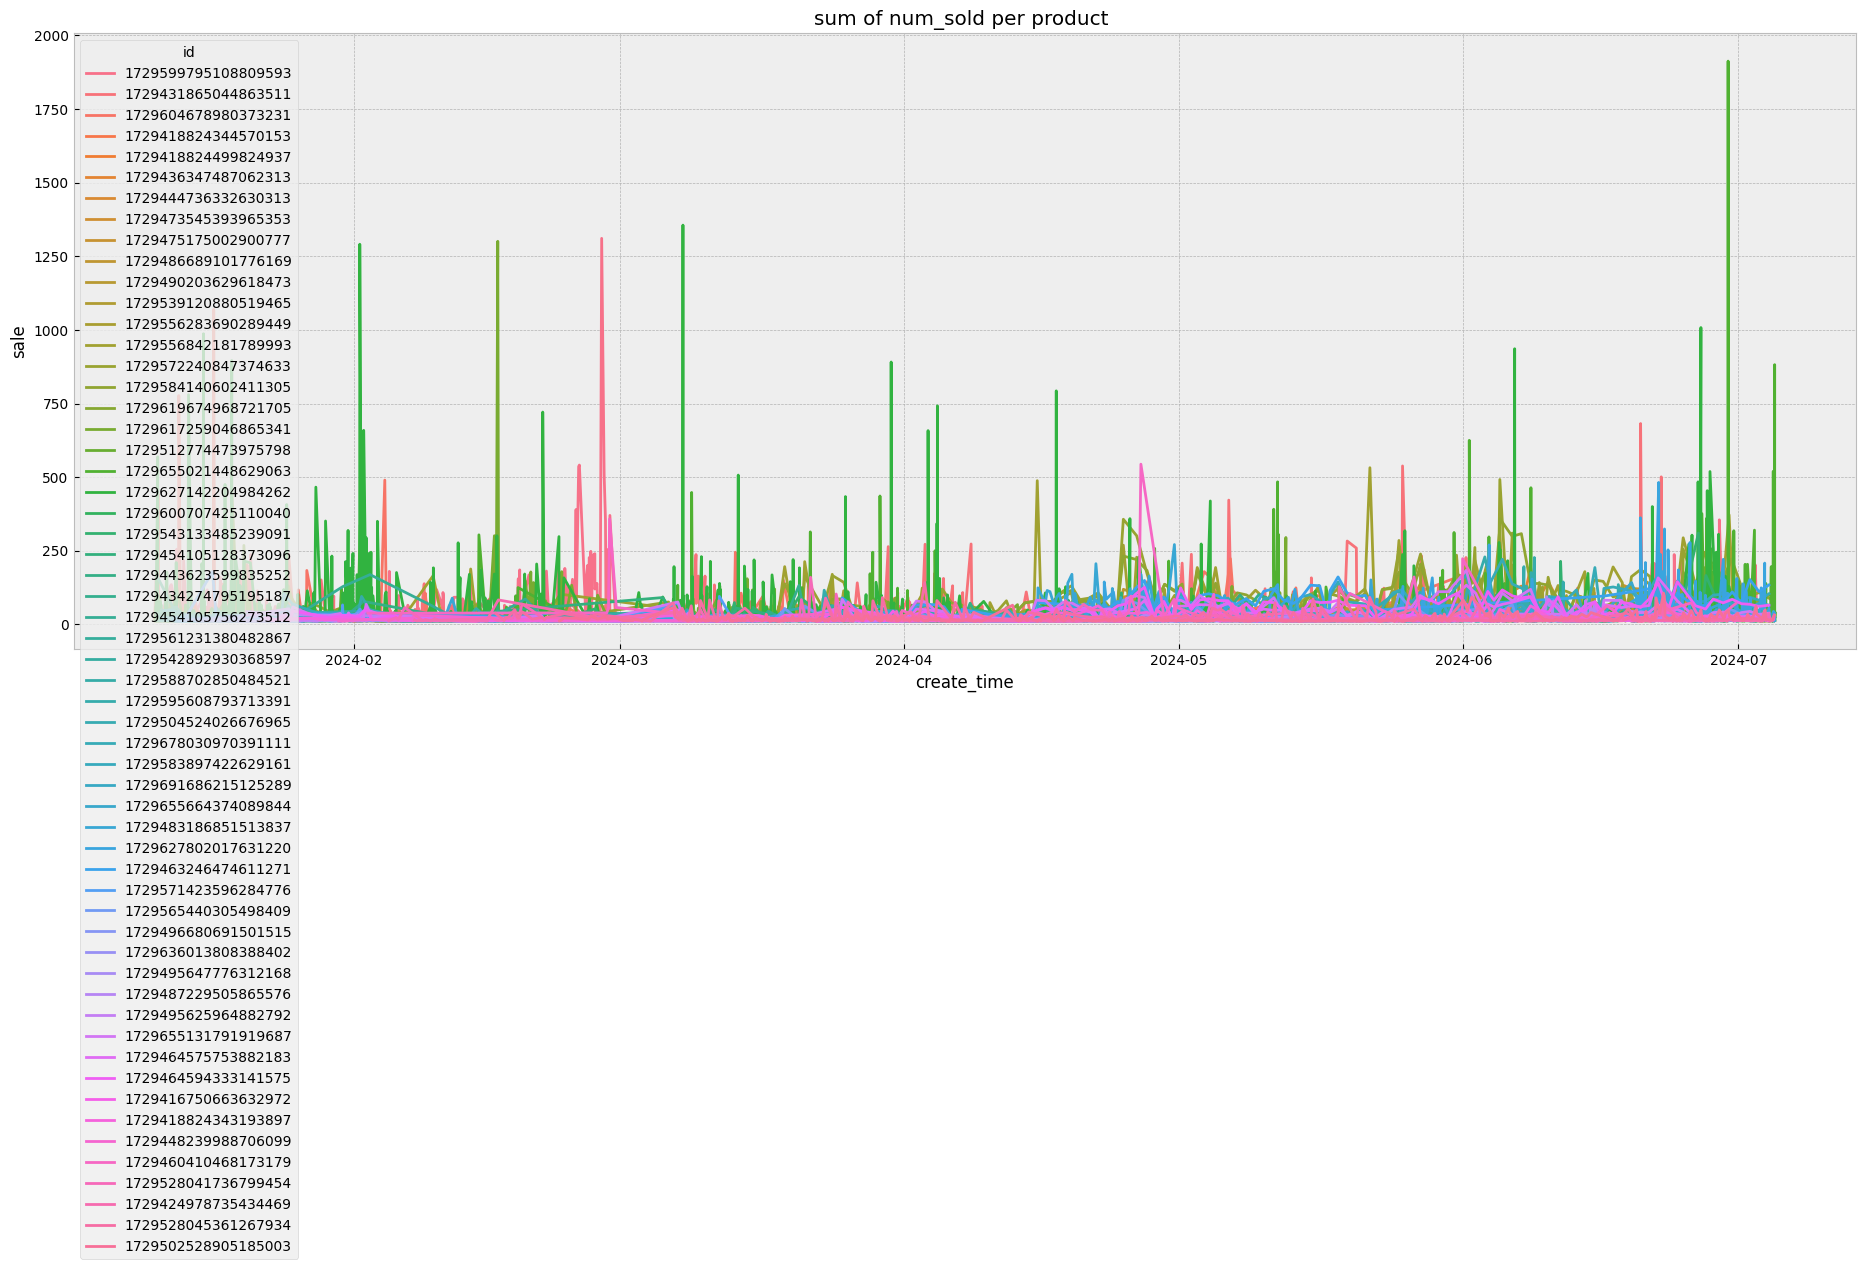

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='create_time',y='sale',hue='id',data=(train_df.groupby(['create_time', 'id']).sale.sum().to_frame()))
ax.set_title("sum of num_sold per product ")

<Axes: title={'center': 'sale'}, xlabel='[id]'>

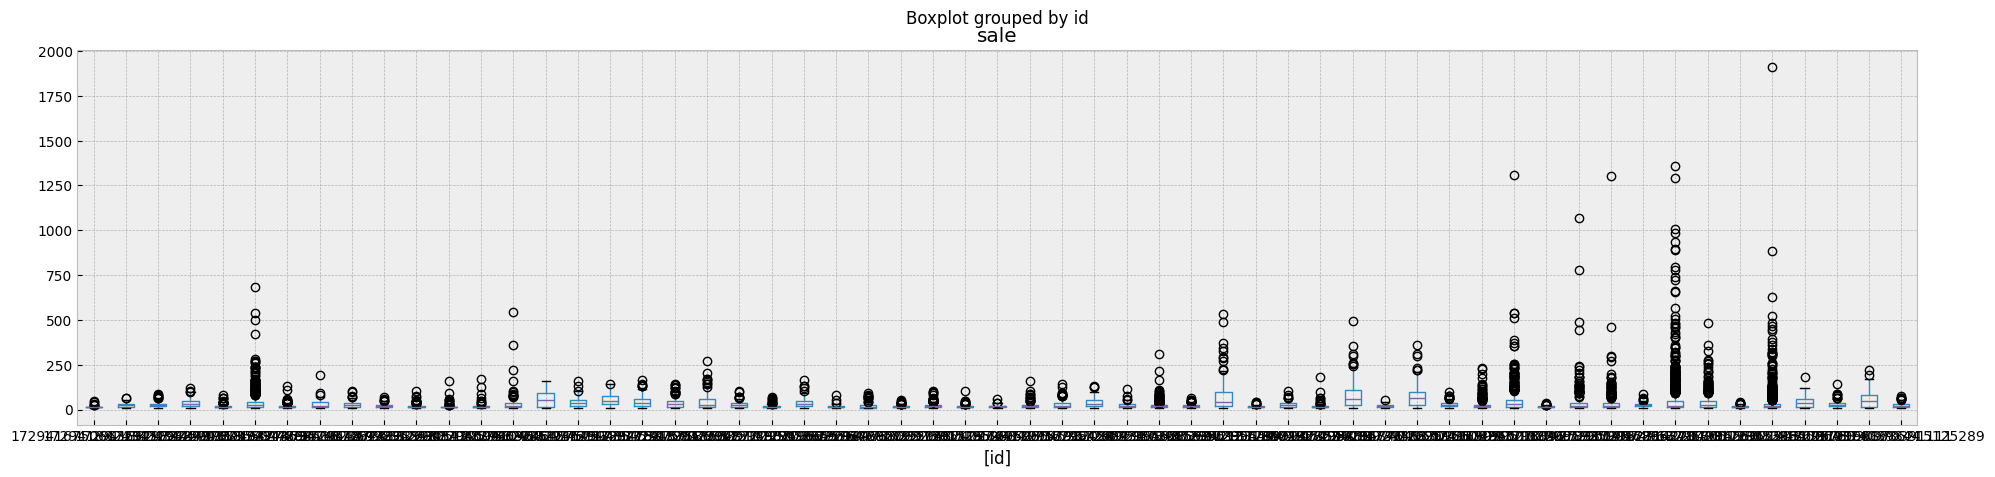

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (23, 5))
train_df.set_index('create_time')[["id", 'sale']].boxplot(by='id', ax=ax)

In [46]:
def remove_outliers(df, column, multiplier=1.0):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Process each product (id)
processed_train = pd.DataFrame()  

for product_id in train_df['id'].unique():
    product_data = train_df[train_df['id'] == product_id]  
    product_data_cleaned = remove_outliers(product_data, 'sale')  
    processed_train = pd.concat([processed_train, product_data_cleaned], ignore_index=True) 

In [47]:
processed_train

,date_only,create_time,id,title,duration,screenshotUrl,sale,views,currency,price,weekday,weekday_sin,weekday_cos,week,week_sin,week_cos,weekend,holidays
0,2024-06-07,2024-06-07 22:00:21,1729416750663632972,TikTok Shop Birthday Fiesta,121,https://live.kalowave.cn/live/7377760664854924...,16.0,4002,฿,5.90,4,-0.433884,-0.900969,23,0.354605,-0.935016,0,0
1,2024-06-25,2024-06-25 22:03:35,1729416750663632972,YOU MY BRAND DAY W TYTY,116,https://live.kalowave.cn/live/7384440983565404...,15.0,11856,฿,5.89,1,0.781831,0.623490,26,-0.0,-1.0,0,0
2,2024-06-22,2024-06-22 22:14:45,1729416750663632972,SATURDAY DEALS w TYTY,121,https://live.kalowave.cn/live/7383330569771371...,12.0,4602,฿,6.72,5,-0.974928,-0.222521,25,0.120537,-0.992709,1,0
3,2024-06-06,2024-06-06 22:01:09,1729416750663632972,TikTok Shop Birthday Fiesta,120,https://live.kalowave.cn/live/7377389743937522...,13.0,7314,฿,5.90,3,0.433884,-0.900969,23,0.354605,-0.935016,0,0
4,2024-06-25,2024-06-25 20:02:23,1729416750663632972,YOU MY BRAND DAY W farah,120,https://live.kalowave.cn/live/7384409976162241...,11.0,8614,฿,5.89,1,0.781831,0.623490,26,-0.0,-1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13504,2024-01-30,2024-01-30 22:21:28,1729655021448629063,tumbler rm,87,https://live.kalowave.cn/live/7329896246260861...,18.0,1580,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
13505,2024-01-30,2024-01-30 08:31:33,1729655021448629063,siapa intai dari luar dia buncit,157,https://live.kalowave.cn/live/7329682180823665...,17.0,553,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
13506,2024-01-30,2024-01-30 08:48:56,1729655021448629063,PERFUME COMBO VIRAL,210,https://live.kalowave.cn/live/7329686622356720...,17.0,927,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
13507,2024-01-30,2024-01-30 10:35:35,1729655021448629063,MENCARI INHALER MEH MASUK SINI,150,https://live.kalowave.cn/live/7329713981948758...,17.0,1393,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0


Text(0.5, 1.0, 'sum of num_sold per product ')

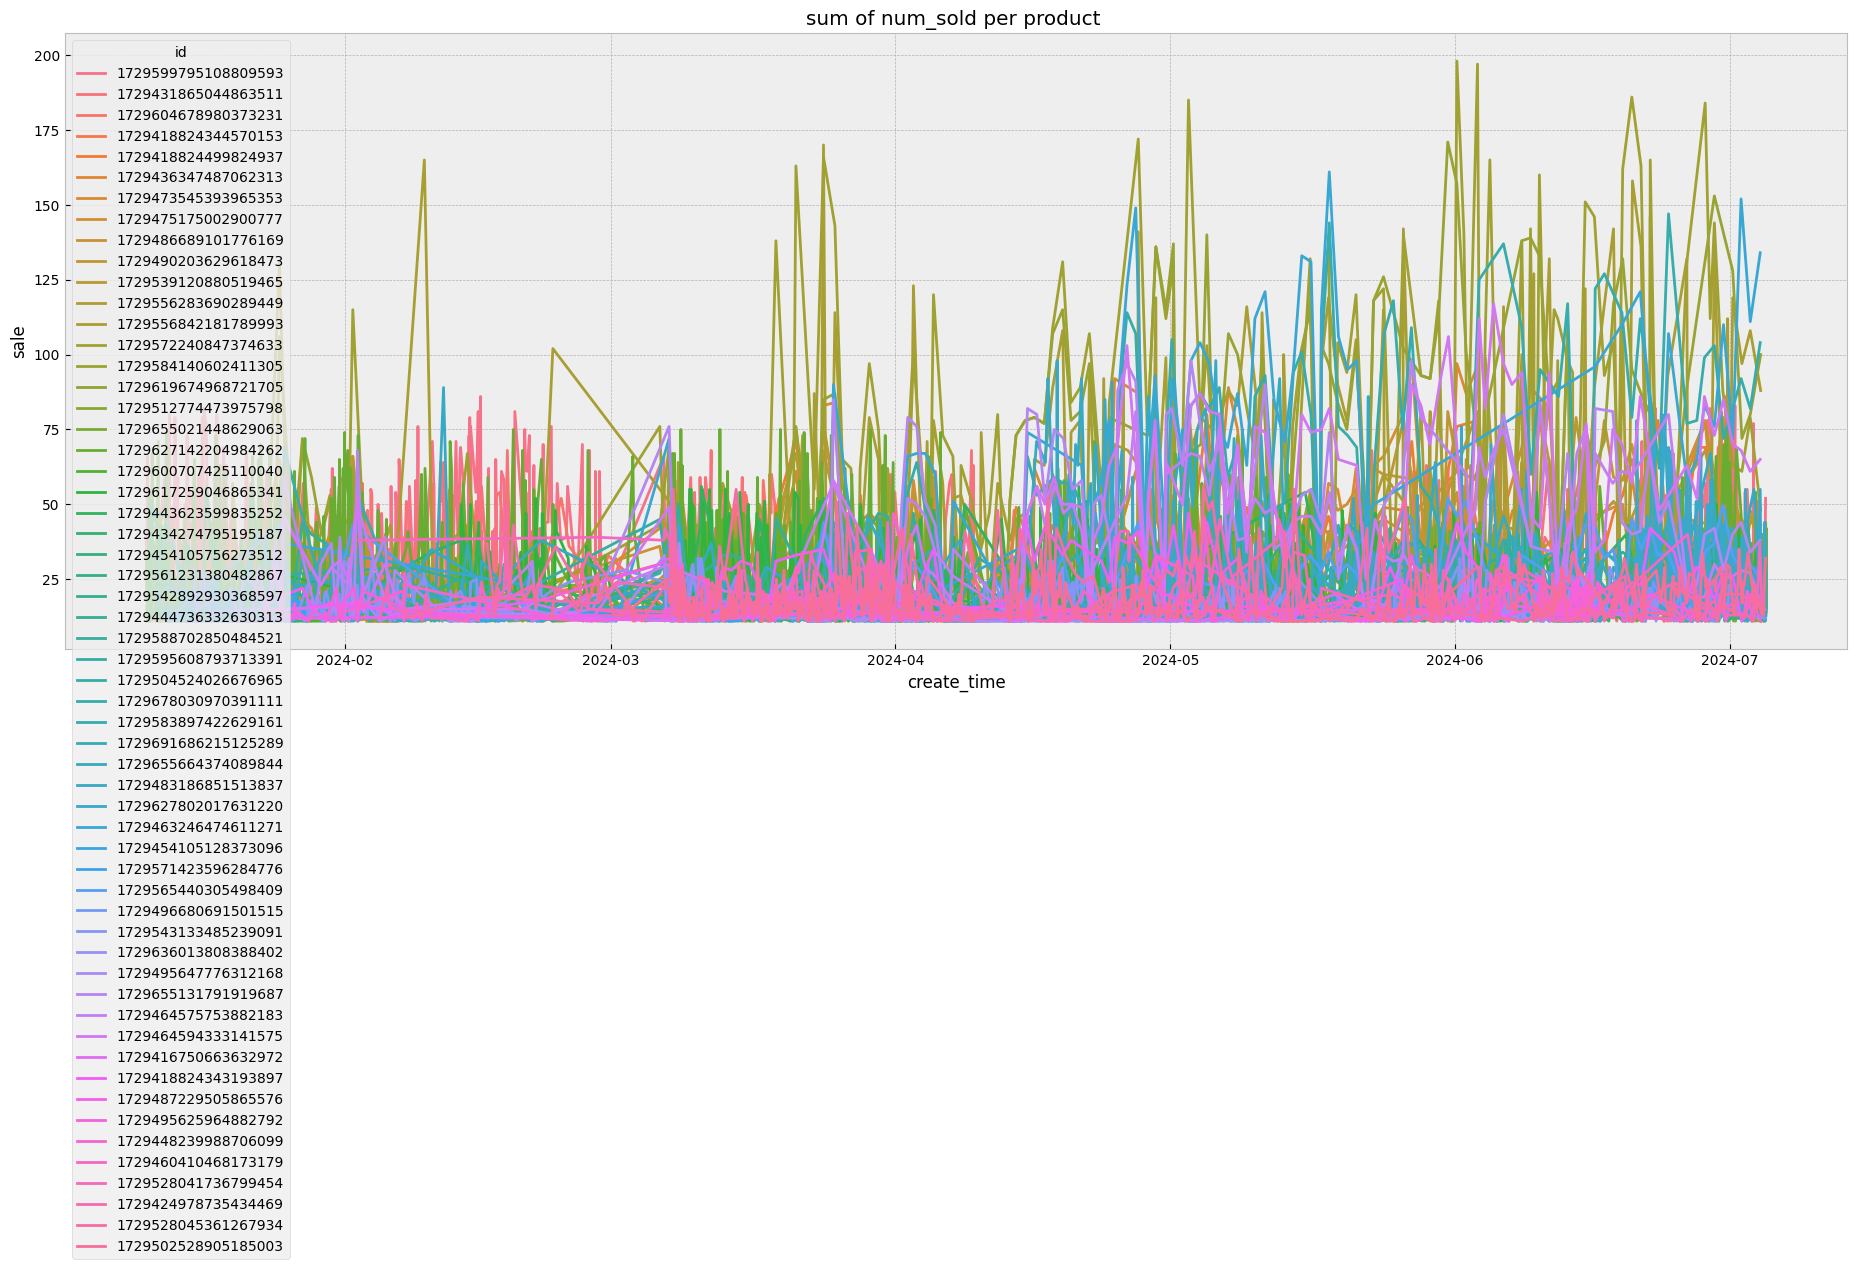

In [48]:
fig, ax = plt.subplots(1, 1, figsize = (23, 8))
sns.lineplot(x='create_time',y='sale',hue='id',data=( processed_train.groupby(['create_time', 'id']).sale.sum().to_frame()))
ax.set_title("sum of num_sold per product ")

<Axes: title={'center': 'sale'}, xlabel='[id]'>

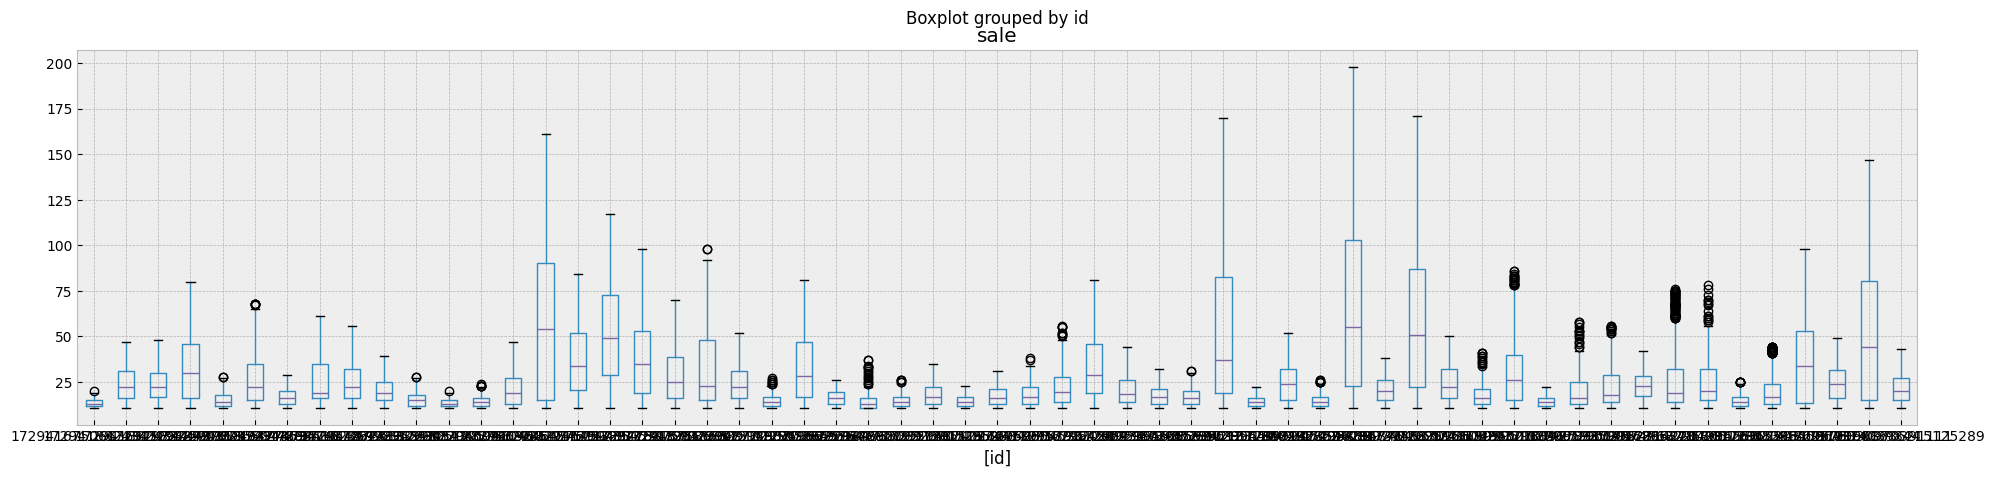

In [49]:
fig, ax = plt.subplots(1, 1, figsize = (23, 5))
processed_train.set_index('create_time')[["id", 'sale']].boxplot(by='id', ax=ax)

In [50]:

id_counts = processed_train['id'].value_counts()
id_counts 

id
1729655021448629063    1298
1729627142204984262    1282
1729431865044863511     989
1729599795108809593     760
1729617259046865341     700
1729502528905185003     541
1729543133485239091     528
1729434274795195187     445
1729627802017631220     318
1729448239988706099     289
1729571423596284776     261
1729604678980373231     242
1729595608793713391     241
1729556842181789993     230
1729496680691501515     184
1729572240847374633     181
1729636013808388402     178
1729528045361267934     174
1729483186851513837     173
1729424978735434469     152
1729655131791919687     150
1729584140602411305     149
1729443623599835252     146
1729678030970391111     140
1729512774473975798     139
1729490203629618473     138
1729475175002900777     134
1729473545393965353     134
1729600707425110040     133
1729418824499824937     133
1729539120880519465     133
1729528041736799454     130
1729495625964882792     127
1729460410468173179     126
1729588702850484521     123
17294541051283730

In [51]:
# Save the updated DataFrame back to a CSV file
processed_train.to_csv('MY13509.csv', index=False)
processed_train

,date_only,create_time,id,title,duration,screenshotUrl,sale,views,currency,price,weekday,weekday_sin,weekday_cos,week,week_sin,week_cos,weekend,holidays
0,2024-06-07,2024-06-07 22:00:21,1729416750663632972,TikTok Shop Birthday Fiesta,121,https://live.kalowave.cn/live/7377760664854924...,16.0,4002,฿,5.90,4,-0.433884,-0.900969,23,0.354605,-0.935016,0,0
1,2024-06-25,2024-06-25 22:03:35,1729416750663632972,YOU MY BRAND DAY W TYTY,116,https://live.kalowave.cn/live/7384440983565404...,15.0,11856,฿,5.89,1,0.781831,0.623490,26,-0.0,-1.0,0,0
2,2024-06-22,2024-06-22 22:14:45,1729416750663632972,SATURDAY DEALS w TYTY,121,https://live.kalowave.cn/live/7383330569771371...,12.0,4602,฿,6.72,5,-0.974928,-0.222521,25,0.120537,-0.992709,1,0
3,2024-06-06,2024-06-06 22:01:09,1729416750663632972,TikTok Shop Birthday Fiesta,120,https://live.kalowave.cn/live/7377389743937522...,13.0,7314,฿,5.90,3,0.433884,-0.900969,23,0.354605,-0.935016,0,0
4,2024-06-25,2024-06-25 20:02:23,1729416750663632972,YOU MY BRAND DAY W farah,120,https://live.kalowave.cn/live/7384409976162241...,11.0,8614,฿,5.89,1,0.781831,0.623490,26,-0.0,-1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13504,2024-01-30,2024-01-30 22:21:28,1729655021448629063,tumbler rm,87,https://live.kalowave.cn/live/7329896246260861...,18.0,1580,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
13505,2024-01-30,2024-01-30 08:31:33,1729655021448629063,siapa intai dari luar dia buncit,157,https://live.kalowave.cn/live/7329682180823665...,17.0,553,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
13506,2024-01-30,2024-01-30 08:48:56,1729655021448629063,PERFUME COMBO VIRAL,210,https://live.kalowave.cn/live/7329686622356720...,17.0,927,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
13507,2024-01-30,2024-01-30 10:35:35,1729655021448629063,MENCARI INHALER MEH MASUK SINI,150,https://live.kalowave.cn/live/7329713981948758...,17.0,1393,฿,1.04,1,0.781831,0.623490,5,0.568065,0.822984,0,0
